<a href="https://colab.research.google.com/github/LokeRuiKee/AChE-GNN/blob/main/DC_GraphConv_Classification_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v2 improvements
1. train validation test set by 70%, 20%, 10% respectively

In [1]:
%%capture
!pip install rdkit
!pip install colorama
!pip install deepchem

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset: Load, Split, Featurize

In [3]:
import pandas as pd
import deepchem as dc
from sklearn.model_selection import train_test_split
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Load the dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/tx2c00283_si_002/SupplementalFiles/Human_dataset_1micromolar.xlsx"
df = pd.read_excel(file_path)

# Specify the columns
smiles_column = "SMILES"
y_column = "single-class-label"

# Split the data into features and target
X = df[smiles_column]
y = df[y_column]

# Split the data into training, validation, and test sets (70%, 20%, 10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Concatenate the features and target for each set
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Define the directory and file paths
base_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/data/process"
train_file = os.path.join(base_dir, "pdY_train.csv")
val_file = os.path.join(base_dir, "pdY_val.csv")
test_file = os.path.join(base_dir, "pdY_test.csv")

# Create the directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Save the data to CSV files
train_data.to_csv(train_file, index=False)
val_data.to_csv(val_file, index=False)
test_data.to_csv(test_file, index=False)

# Load and Featurize the data using DeepChem
tasks = ["single-class-label"]
ntasks = len(tasks)
featurizer_func = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field='SMILES', featurizer=featurizer_func)

train_dataset = loader.create_dataset(train_file)
val_dataset = loader.create_dataset(val_file)
test_dataset = loader.create_dataset(test_file)

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


# Model Construction

## Model 1 graph_conv_layers = [64, 64, 64], dense_layer_size=128, dropout=0

Classification mode of DeepChem's GraphConvModel. Completion of Model 1 date: 3/6/2024

In [22]:
batch_size = 64
batches_per_epoch = 600/batch_size
learning_rate = dc.models.optimizers.ExponentialDecay(0.0001, 0.9, batches_per_epoch)

model = dc.models.GraphConvModel(ntasks,
                                 graph_conv_layers=[64, 64, 64],
                                 dense_layer_size=128,
                                 dropout=0.,
                                 batch_normalize=True,
                                 mode='classification',
                                 batch_size=batch_size,
                                 learning_rate=learning_rate,
                                 model_dir='/content/drive/MyDrive/Colab Notebooks/FYP1/DeepChemGCNModels')
model.fit(train_dataset)
model.save_checkpoint()

In [23]:
metrics = [dc.metrics.Metric(dc.metrics.accuracy_score),
           dc.metrics.Metric(dc.metrics.f1_score),
           dc.metrics.Metric(dc.metrics.roc_auc_score)]

for metric in metrics:
    print("Train", metric.name, ":", model.evaluate(train_dataset, [metric]))
    print("Test", metric.name, ":", model.evaluate(test_dataset, [metric]))

Train accuracy_score : {'accuracy_score': 0.7316503038803179}
Test accuracy_score : {'accuracy_score': 0.7230392156862745}
Train f1_score : {'f1_score': 0.71751968503937}
Test f1_score : {'f1_score': 0.7328605200945627}
Train roc_auc_score : {'roc_auc_score': 0.8173833964520629}
Test roc_auc_score : {'roc_auc_score': 0.8094471153846153}


In [24]:
model.model.summary()

Model: "private__graph_conv_keras_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_conv_35 (GraphConv)   multiple                  102144    
                                                                 
 graph_conv_36 (GraphConv)   multiple                  87360     
                                                                 
 graph_conv_37 (GraphConv)   multiple                  87360     
                                                                 
 batch_normalization_47 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_48 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_49 (Ba  mul

Result 3/6/2024
- Train accuracy_score : {'accuracy_score': 0.7832310838445807}
- Test accuracy_score : {'accuracy_score': 0.7484662576687117}
- Train f1_score : {'f1_score': 0.7663139329805997}
- Test f1_score : {'f1_score': 0.7496947496947497}
- Train roc_auc_score : {'roc_auc_score': 0.8593345580730762}
- Test roc_auc_score : {'roc_auc_score': 0.8255188548412382}

### Inference

In [6]:
# Test case for class 1
from rdkit import Chem


# Define a new SMILES string
new_smiles = "Nc1c2c(nc3c1CCC3)CCCC2"

# Create a ConvMolFeaturizer
featurizer = dc.feat.ConvMolFeaturizer()

# Convert the SMILES string to the format expected by the model
new_mol = Chem.MolFromSmiles(new_smiles)
new_data = featurizer.featurize([new_mol])

# Create a Dataset object from the new data
new_dataset = dc.data.NumpyDataset(new_data)

# Predict the class probabilities for the new data
new_pred_probs = model.predict(new_dataset)

# Select the probabilities of the first task
new_pred_probs = new_pred_probs[:, 0]

# Convert the predicted probabilities to class labels
new_preds = np.argmax(new_pred_probs, axis=1)

print("Predicted probs for new data:", new_pred_probs[0])
print("Predicted class for new data:", new_preds[0])

Predicted probs for new data: [0.14498833 0.85501164]
Predicted class for new data: 1


In [7]:
# Test case for class 0

# Define a new SMILES string
new_smiles = "Cc1ccc(OP(=O)(N(C)C)N2CCOCC2)cc1"

# Create a ConvMolFeaturizer
featurizer = dc.feat.ConvMolFeaturizer()

# Convert the SMILES string to the format expected by the model
new_mol = Chem.MolFromSmiles(new_smiles)
new_data = featurizer.featurize([new_mol])

# Create a Dataset object from the new data
new_dataset = dc.data.NumpyDataset(new_data)

# Predict the class probabilities for the new data
new_pred_probs = model.predict(new_dataset)

# Select the probabilities of the first task
new_pred_probs = new_pred_probs[:, 0]

# Convert the predicted probabilities to class labels
new_preds = np.argmax(new_pred_probs, axis=1)

print("Predicted probs for new data:", new_pred_probs[0])
print("Predicted class for new data:", new_preds[0])

Predicted probs for new data: [0.89092106 0.10907897]
Predicted class for new data: 0


In [8]:
# Test case for class 1

# Define a new SMILES string
new_smiles = "COc1ccc2nc(NCCc3cc[n+](Cc4ccccc4)cc3)sc2c1"

# Create a ConvMolFeaturizer
featurizer = dc.feat.ConvMolFeaturizer()

# Convert the SMILES string to the format expected by the model
new_mol = Chem.MolFromSmiles(new_smiles)
new_data = featurizer.featurize([new_mol])

# Create a Dataset object from the new data
new_dataset = dc.data.NumpyDataset(new_data)

# Predict the class probabilities for the new data
new_pred_probs = model.predict(new_dataset)

# Select the probabilities of the first task
new_pred_probs = new_pred_probs[:, 0]

# Convert the predicted probabilities to class labels
new_preds = np.argmax(new_pred_probs, axis=1)

print("Predicted probs for new data:", new_pred_probs[0])
print("Predicted class for new data:", new_preds[0])

Predicted probs for new data: [0.41167313 0.5883269 ]
Predicted class for new data: 1


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Test case with test dataset

# Get the predicted probabilities
pred_probs = model.predict(test_dataset)

# Select the probabilities of the first task
pred_probs = pred_probs[:, 0]

# Convert the predicted probabilities to class labels
preds = np.argmax(pred_probs, axis=1)

# True labels for the test set
true_labels = y_test

# Calculate performance metrics
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, average='weighted')
recall = recall_score(true_labels, preds, average='weighted')
f1 = f1_score(true_labels, preds, average='weighted')

# Print the results
print("Test dataset: ", test_dataset)
print("True labels: ", true_labels)
print("Predicted probabilities (first task): ", pred_probs)
print("Predicted class: ", preds)

print("\nAccuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, preds)
print("\nConfusion Matrix:\n", conf_matrix)

Test dataset:  <DiskDataset X.shape: (408,), y.shape: (408, 1), w.shape: (408, 1), ids: ['Nc1c2c(nc3c1CCC3)CCCC2' 'COc1cc2[se]n(-c3ccc(CN4CCCCC4)cc3)c(=O)c2cc1OC'
 'COc1cc2c(cc1O)CCC(C)(CCC(=O)NCCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2' ...
 'Cc1c(C)c2ccc(OCC3CCN(Cc4cccc(CO[N+](=O)[O-])c4)CC3)cc2oc1=O'
 'COc1cc(/C=N/O)c(O)c(CN2CCC(CN3CCc4cc(OC)c(OC)cc4C3c3ccccc3)CC2)c1'
 'CN(Cc1ccccc1)Cc1ccc(C(=O)c2ccc(OCCCCCN3CCCCC3)cc2)cc1'], task_names: ['single-class-label']>
True labels:  1749    1
2053    0
538     1
438     1
2684    0
       ..
2422    0
1744    1
2014    0
3930    0
1237    1
Name: single-class-label, Length: 408, dtype: int64
Predicted probabilities (first task):  [[0.14498845 0.8550116 ]
 [0.29325658 0.70674336]
 [0.02125362 0.97874635]
 [0.3589916  0.64100844]
 [0.9516703  0.04832958]
 [0.25487548 0.74512446]
 [0.08912505 0.91087496]
 [0.12508047 0.8749196 ]
 [0.76850295 0.23149697]
 [0.3335263  0.6664738 ]
 [0.3028434  0.6971566 ]
 [0.93663275 0.06336724]
 [0.05144465 0.94855

In [10]:
# check pred_probs.shape should be 2 for binary classification
# check true_labels.shape. shape is (815,), this means 815 samples in test set with a single label per sample.
print(pred_probs.shape)
print(true_labels.shape)

(408, 2)
(408,)


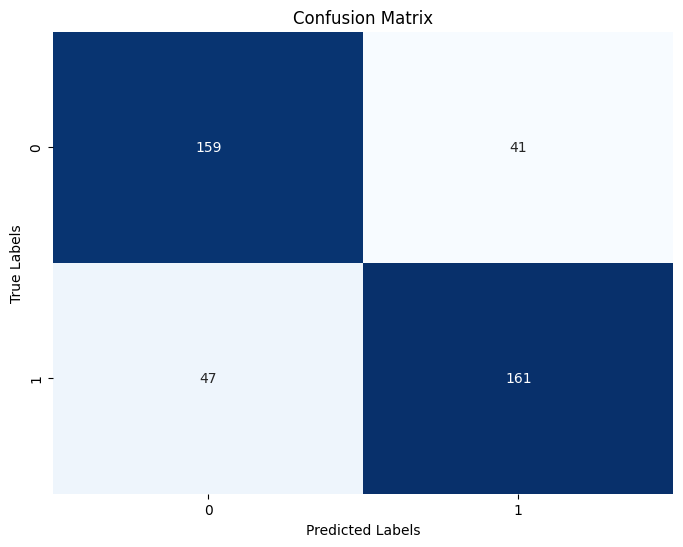

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Additional (for understanding)

## Visualize the use of ConvMolFeaturizer

Featurize the Data: Convert the SMILES strings into graph-based features using the ConvMolFeaturizer.

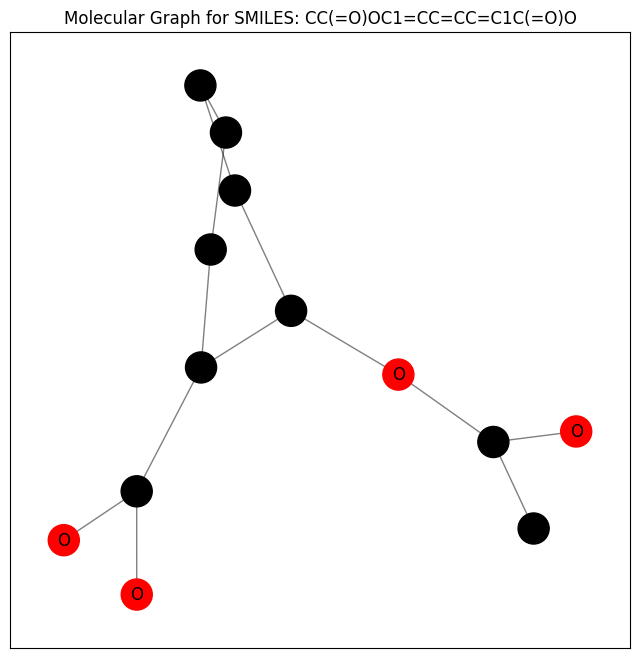

In [12]:
# Visualize the use of ConvMolFeaturizer

from deepchem.feat import ConvMolFeaturizer
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt

# Example SMILES string
smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'

# Featurize the SMILES string
featurizer = ConvMolFeaturizer()
mol_features = featurizer.featurize([smiles])[0]

# Extract the molecule
rdkit_mol = Chem.MolFromSmiles(smiles)

# Create a NetworkX graph from RDKit molecule
G = nx.Graph()
for atom in rdkit_mol.GetAtoms():
    G.add_node(atom.GetIdx(), label=atom.GetSymbol())

for bond in rdkit_mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), order=bond.GetBondType())

# Define a color map for atoms (optional)
atom_colors = {
    'H': 'white',
    'C': 'black',
    'O': 'red',
    'N': 'blue',
    'S': 'yellow',
    'F': 'green',
    'Cl': 'green',
    'Br': 'brown',
    'I': 'purple'
}

# Get atom symbols for coloring
colors = [atom_colors[rdkit_mol.GetAtomWithIdx(i).GetSymbol()] for i in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, {i: rdkit_mol.GetAtomWithIdx(i).GetSymbol() for i in G.nodes()})
plt.title("Molecular Graph for SMILES: {}".format(smiles))
plt.show()

# Nested 5 fold cross validation

In [ ]:
import deepchem as dc
import numpy as np
from sklearn.model_selection import KFold

# Load and Featurize the data using DeepChem
tasks = ["single-class-label"]
ntasks = len(tasks)
featurizer_func = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field='SMILES', featurizer=featurizer_func)

# Load datasets
train_dataset = loader.create_dataset(train_file)
val_dataset = loader.create_dataset(val_file)
test_dataset = loader.create_dataset(test_file)

# Concatenate train and test datasets for cross-validation
dataset = dc.data.DiskDataset.merge([train_dataset, test_dataset])

# Get the features (X) and labels (y) from the dataset
X = dataset.X
y = dataset.y

# Initialize the outer KFold
outer_kf = KFold(n_splits=5, shuffle=True, random_state=1)

outer_accuracies = []
outer_f1_scores = []
outer_roc_auc_scores = []

batch_size = 64
batches_per_epoch = 600/batch_size
learning_rate = dc.models.optimizers.ExponentialDecay(0.0001, 0.9, batches_per_epoch)

for outer_train_index, outer_test_index in outer_kf.split(X):
    # Split the data for the outer loop
    outer_X_train, outer_X_test = X[outer_train_index], X[outer_test_index]
    outer_y_train, outer_y_test = y[outer_train_index], y[outer_test_index]

    # Initialize the inner KFold
    inner_kf = KFold(n_splits=5, shuffle=True, random_state=1)
    inner_accuracies = []
    inner_f1_scores = []
    inner_roc_auc_scores = []

    for inner_train_index, inner_val_index in inner_kf.split(outer_X_train):
        # Split the data for the inner loop
        inner_X_train, inner_X_val = outer_X_train[inner_train_index], outer_X_train[inner_val_index]
        inner_y_train, inner_y_val = outer_y_train[inner_train_index], outer_y_train[inner_val_index]

        # Create train and validation datasets for DeepChem
        train_dataset = dc.data.NumpyDataset(inner_X_train, inner_y_train)
        val_dataset = dc.data.NumpyDataset(inner_X_val, inner_y_val)

        # Initialize the model
        batches_per_epoch = len(inner_X_train) / batch_size
        learning_rate = dc.models.optimizers.ExponentialDecay(0.0001, 0.9, batches_per_epoch)
        model = dc.models.GraphConvModel(ntasks,
                                         graph_conv_layers=[64, 64, 64],
                                         dense_layer_size=128,
                                         dropout=0.,
                                         batch_normalize=True,
                                         mode='classification',
                                         batch_size=batch_size,
                                         learning_rate=learning_rate,
                                         model_dir='/content/drive/MyDrive/Colab Notebooks/FYP1/DeepChemGCNModels')

        # Train the model
        model.fit(train_dataset)

        # Evaluate the model on the validation set
        val_scores = model.evaluate(val_dataset, [dc.metrics.Metric(dc.metrics.accuracy_score),
                                                  dc.metrics.Metric(dc.metrics.f1_score),
                                                  dc.metrics.Metric(dc.metrics.roc_auc_score)])
        inner_accuracies.append(val_scores['accuracy_score'])
        inner_f1_scores.append(val_scores['f1_score'])
        inner_roc_auc_scores.append(val_scores['roc_auc_score'])

    # Average the inner fold scores for hyperparameter selection
    avg_inner_accuracy = np.mean(inner_accuracies)
    avg_inner_f1_score = np.mean(inner_f1_scores)
    avg_inner_roc_auc_score = np.mean(inner_roc_auc_scores)

    # Create the final train and test datasets for the outer loop
    final_train_dataset = dc.data.NumpyDataset(outer_X_train, outer_y_train)
    final_test_dataset = dc.data.NumpyDataset(outer_X_test, outer_y_test)

    # Train the model on the entire outer training data
    model.fit(final_train_dataset)

    # Evaluate the model on the outer test set
    outer_test_scores = model.evaluate(final_test_dataset, [dc.metrics.Metric(dc.metrics.accuracy_score),
                                                            dc.metrics.Metric(dc.metrics.f1_score),
                                                            dc.metrics.Metric(dc.metrics.roc_auc_score)])
    outer_accuracies.append(outer_test_scores['accuracy_score'])
    outer_f1_scores.append(outer_test_scores['f1_score'])
    outer_roc_auc_scores.append(outer_test_scores['roc_auc_score'])

# Compute the average scores across all outer folds
final_accuracy = np.mean(outer_accuracies)
final_f1_score = np.mean(outer_f1_scores)
final_roc_auc_score = np.mean(outer_roc_auc_scores)

print(f'Final Accuracy: {final_accuracy}')
print(f'Final F1 Score: {final_f1_score}')
print(f'Final ROC AUC Score: {final_roc_auc_score}')

# Default

# Model 11

In [16]:
# Dataset loaded from before

# Initialize model
model = dc.models.GraphConvModel(n_tasks=len(tasks), mode='classification')

# Train model
model.fit(train_dataset, nb_epoch=50)

# Evaluate model
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
print("Training set score:", model.evaluate(train_dataset, [metric]))
print("Test set score:", model.evaluate(test_dataset, [metric]))

Training set score: {'mean-roc_auc_score': 0.9938130000854237}
Test set score: {'mean-roc_auc_score': 0.9720192307692308}


In [21]:
model.model.summary()

Model: "private__graph_conv_keras_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_conv_33 (GraphConv)   multiple                  102144    
                                                                 
 graph_conv_34 (GraphConv)   multiple                  87360     
                                                                 
 batch_normalization_44 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_45 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_46 (Ba  multiple                  512       
 tchNormalization)                                               
                                

# Best (Model 18)

In [34]:
# default
# Dataset loaded from before

# Initialize model
model = dc.models.GraphConvModel(n_tasks=len(tasks), mode='classification')

# Train model
model.fit(train_dataset, nb_epoch=50)

metrics = [dc.metrics.Metric(dc.metrics.accuracy_score),
           dc.metrics.Metric(dc.metrics.f1_score),
           dc.metrics.Metric(dc.metrics.roc_auc_score)]

for metric in metrics:
    print("Train", metric.name, ":", model.evaluate(train_dataset, [metric]))
    print("Test", metric.name, ":", model.evaluate(test_dataset, [metric]))

Train accuracy_score : {'accuracy_score': 0.956989247311828}
Test accuracy_score : {'accuracy_score': 0.9044117647058824}
Train f1_score : {'f1_score': 0.9491150442477876}
Test f1_score : {'f1_score': 0.9027431421446385}
Train roc_auc_score : {'roc_auc_score': 0.9948612218457245}
Test roc_auc_score : {'roc_auc_score': 0.9595913461538461}


In [35]:
model.model.summary()

Model: "private__graph_conv_keras_model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_conv_48 (GraphConv)   multiple                  102144    
                                                                 
 graph_conv_49 (GraphConv)   multiple                  87360     
                                                                 
 batch_normalization_66 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_67 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_68 (Ba  multiple                  512       
 tchNormalization)                                               
                                

# Model 17

In [ ]:
import numpy as np
import deepchem as dc

# Assuming train_dataset and test_dataset are already defined and loaded

# Initialize model
model = dc.models.GraphConvModel(n_tasks=len(tasks), mode='classification')

# Train model
model.fit(train_dataset, nb_epoch=50)

In [32]:
metrics = [dc.metrics.Metric(dc.metrics.accuracy_score),
           dc.metrics.Metric(dc.metrics.f1_score),
           dc.metrics.Metric(dc.metrics.roc_auc_score)]

for metric in metrics:
    print("Train", metric.name, ":", model.evaluate(train_dataset, [metric]))
    print("Test", metric.name, ":", model.evaluate(test_dataset, [metric]))

Train accuracy_score : {'accuracy_score': 0.9504441327723235}
Test accuracy_score : {'accuracy_score': 0.8970588235294118}
Train f1_score : {'f1_score': 0.9411764705882354}
Test f1_score : {'f1_score': 0.8960396039603961}
Train roc_auc_score : {'roc_auc_score': 0.9936314744155585}
Test roc_auc_score : {'roc_auc_score': 0.9639903846153846}


In [27]:
print(train_dataset)

<NumpyDataset X.shape: (2139,), y.shape: (2139, 1), w.shape: (2139, 1), task_names: [0]>


In [33]:
model.model.summary()

Model: "private__graph_conv_keras_model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_conv_46 (GraphConv)   multiple                  102144    
                                                                 
 graph_conv_47 (GraphConv)   multiple                  87360     
                                                                 
 batch_normalization_63 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_64 (Ba  multiple                  256       
 tchNormalization)                                               
                                                                 
 batch_normalization_65 (Ba  multiple                  512       
 tchNormalization)                                               
                                

# Nested 5 fold cross validation based on model 18

In [49]:
# refactored

import deepchem as dc
import numpy as np
from sklearn.model_selection import KFold

# Load and Featurize the data using DeepChem
tasks = ["single-class-label"]
ntasks = len(tasks)
featurizer_func = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field='SMILES', featurizer=featurizer_func)

# Load datasets
train_dataset = loader.create_dataset(train_file)
val_dataset = loader.create_dataset(val_file)
test_dataset = loader.create_dataset(test_file)

# Concatenate train and test datasets for cross-validation
dataset = dc.data.DiskDataset.merge([train_dataset, test_dataset])

# Get the features (X) and labels (y) from the dataset
X = dataset.X
y = dataset.y

# Initialize the outer KFold
outer_kf = KFold(n_splits=5, shuffle=True, random_state=1)

outer_accuracies = []
outer_f1_scores = []
outer_roc_auc_scores = []

# Initialize the model outside the loop
model = dc.models.GraphConvModel(n_tasks=len(tasks), mode='classification')

for outer_train_index, outer_test_index in outer_kf.split(X):
    outer_X_train, outer_X_test = X[outer_train_index], X[outer_test_index]
    outer_y_train, outer_y_test = y[outer_train_index], y[outer_test_index]

    # Initialize the inner KFold
    inner_kf = KFold(n_splits=5, shuffle=True, random_state=1)
    inner_accuracies = []
    inner_f1_scores = []
    inner_roc_auc_scores = []

    for inner_train_index, inner_val_index in inner_kf.split(outer_X_train):
        inner_X_train, inner_X_val = outer_X_train[inner_train_index], outer_X_train[inner_val_index]
        inner_y_train, inner_y_val = outer_y_train[inner_train_index], outer_y_train[inner_val_index]

        train_dataset = dc.data.NumpyDataset(inner_X_train, inner_y_train)
        val_dataset = dc.data.NumpyDataset(inner_X_val, inner_y_val)

        # Train the model using pre-defined function
        model.fit(train_dataset, nb_epoch=50)

        # Evaluate using pre-defined function
        val_scores = model.evaluate(val_dataset, [dc.metrics.Metric(dc.metrics.accuracy_score),
                                                  dc.metrics.Metric(dc.metrics.f1_score),
                                                  dc.metrics.Metric(dc.metrics.roc_auc_score)])
        inner_accuracies.append(val_scores['accuracy_score'])
        inner_f1_scores.append(val_scores['f1_score'])
        inner_roc_auc_scores.append(val_scores['roc_auc_score'])

    avg_inner_accuracy = np.mean(inner_accuracies)
    avg_inner_f1_score = np.mean(inner_f1_scores)
    avg_inner_roc_auc_score = np.mean(inner_roc_auc_scores)

    final_train_dataset = dc.data.NumpyDataset(outer_X_train, outer_y_train)
    final_test_dataset = dc.data.NumpyDataset(outer_X_test, outer_y_test)

    # Train on the entire outer training data using pre-defined function
    model.fit(final_train_dataset, nb_epoch=50)

    # Evaluate on the outer test set using pre-defined function
    outer_test_scores = model.evaluate(final_test_dataset, [dc.metrics.Metric(dc.metrics.accuracy_score),
                                                            dc.metrics.Metric(dc.metrics.f1_score),
                                                            dc.metrics.Metric(dc.metrics.roc_auc_score)])
    outer_accuracies.append(outer_test_scores['accuracy_score'])
    outer_f1_scores.append(outer_test_scores['f1_score'])
    outer_roc_auc_scores.append(outer_test_scores['roc_auc_score'])

final_accuracy = np.mean(outer_accuracies)
final_f1_score = np.mean(outer_f1_scores)
final_roc_auc_score = np.mean(outer_roc_auc_scores)

print(f'Final Accuracy: {final_accuracy}')
print(f'Final F1 Score: {final_f1_score}')
print(f'Final ROC AUC Score: {final_roc_auc_score}')

Final Accuracy: 0.9114260268700267
Final F1 Score: 0.9000183415801821
Final ROC AUC Score: 0.9664856978565657


In [50]:
model.model.summary()

Model: "private__graph_conv_keras_model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_conv_108 (GraphConv)  multiple                  102144    
                                                                 
 graph_conv_109 (GraphConv)  multiple                  87360     
                                                                 
 batch_normalization_156 (B  multiple                  256       
 atchNormalization)                                              
                                                                 
 batch_normalization_157 (B  multiple                  256       
 atchNormalization)                                              
                                                                 
 batch_normalization_158 (B  multiple                  512       
 atchNormalization)                                              
                                

In [57]:
model.save_checkpoint(model_dir='/content/drive/MyDrive/Colab Notebooks/FYP1/DeepChemGCNModels/Best_model_17.6')

In [60]:
# check if the checkpoint files are saved correctly
model.get_checkpoints(model_dir='/content/drive/MyDrive/Colab Notebooks/FYP1/DeepChemGCNModels/Best_model_17.6')

['/content/drive/MyDrive/Colab Notebooks/FYP1/DeepChemGCNModels/Best_model_17.6/ckpt-66']

In [61]:
import json

results = {
    'final_accuracy': final_accuracy,
    'final_f1_score': final_f1_score,
    'final_roc_auc_score': final_roc_auc_score,
    'outer_accuracies': outer_accuracies,
    'outer_f1_scores': outer_f1_scores,
    'outer_roc_auc_scores': outer_roc_auc_scores
}

with open('model_results.json', 'w') as f:
    json.dump(results, f)

In [64]:
model.restore(model_dir='/content/drive/MyDrive/Colab Notebooks/FYP1/DeepChemGCNModels/Best_model_17.6')